In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
import datetime
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

from sklearn import linear_model
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import warnings
warnings.filterwarnings("ignore")

# Scaleing Dataframe

In [3]:
df = pd.read_csv('no_dummy_df.scv')
scaler = StandardScaler()
scaler_data = scaler.fit_transform(df)
scaler_df = pd.DataFrame(scaler_data, columns = df.columns.to_list())

In [5]:
X = scaler_df.drop(['price'],axis=1, inplace=False)
y = scaler_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model written by Jiyin and trained by Lai – using scaler dataframe but with no dummy variables

## XGBoost

In [22]:
xgboost_params = {
    'n_estimators': hp.quniform('n_estimators', 800, 2400, 400),
    'max_depth':hp.quniform('max_depth', 5, 12, 1),
    'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1, 0.05),
    'min_child_weight':hp.quniform('min_child_weight', 1,6,1),
}

def hyperparameter_tuning_xgboost(space):
    clf = XGBRegressor(n_estimators=int(space['n_estimators']), 
                       max_depth=int(space['max_depth']), min_child_weight=space['min_child_weight'],
                       colsample_bytree=space['colsample_bytree'], learning_rate=0.01,
                       seed=42)
    
    evaluation = [(X_test, y_test)]
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=200, verbose=False)
    y_pred = clf.predict(X_test)
    rmse = np.sqrt(((y_test-y_pred)**2).mean())
    return {'loss': rmse, 'status': STATUS_OK}

trials = Trials()
xgboost_best = fmin(fn=hyperparameter_tuning_xgboost, space=xgboost_params, algo=tpe.suggest,
                    max_evals=200, trials=trials)

xgb = XGBRegressor(n_estimators=int(xgboost_best['n_estimators']), 
                   max_depth=int(xgboost_best['max_depth']), min_child_weight=xgboost_best['min_child_weight'],
                   colsample_bytree=xgboost_best['colsample_bytree'], learning_rate=0.01,
                   seed=42)
evaluation = [(X_test, y_test)]
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

test_score_xg = xgb.score(X_test, y_test)
train_score_xg = xgb.score(X_train, y_train)

100%|██████████████████████████████████████████████| 200/200 [35:01<00:00, 10.51s/trial, best loss: 0.6694743523224415]


In [23]:
test_score_xg

0.30037708067766644

In [24]:
train_score_xg

0.9711994006811975

In [25]:
xgboost_best

{'colsample_bytree': 0.35000000000000003,
 'max_depth': 7.0,
 'min_child_weight': 1.0,
 'n_estimators': 2400.0}

In [37]:
feature_names = X_train.columns.to_list()

Text(0.5, 0, 'Relative Importanceog XGBoost without dummy')

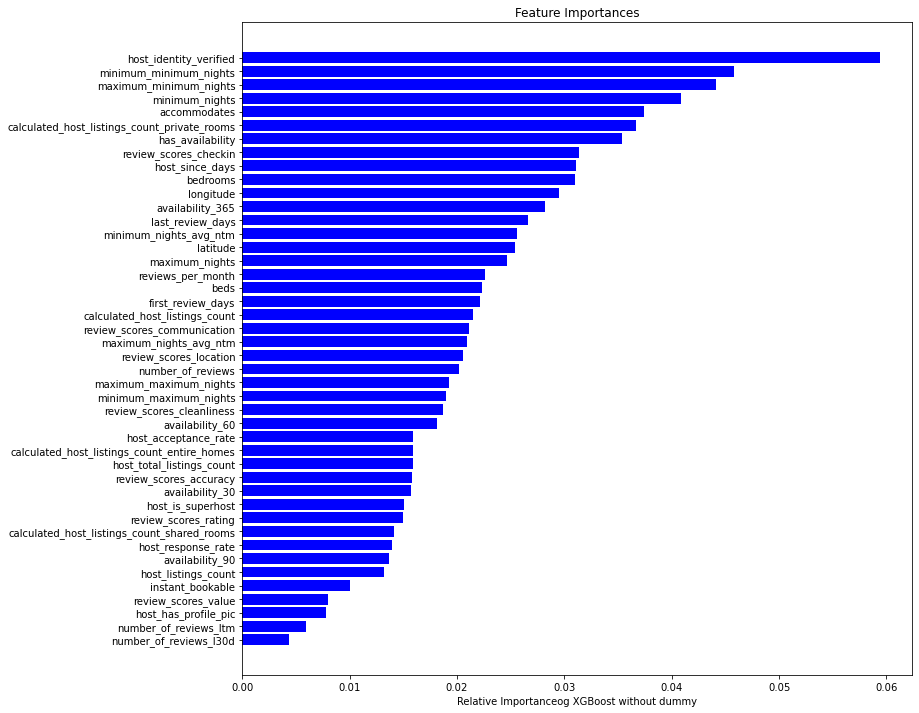

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = xgb.feature_importances_
indices = np.argsort(importances)
#indices = indices[988-50:]

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)),feature_names)
plt.yticks(range(len(indices)),np.array(feature_names)[indices])
plt.xlabel('Relative Importanceog XGBoost without dummy')


## CatBoost (GridSearch)

In [27]:
params = {
    'n_estimators': [100,300,500,800],
    'learning_rate':[0.01],
    'max_depth':np.arange(5, 12),
    'colsample_bylevel':np.arange(0.1, 0.8, 0.05),
    'min_child_samples':np.arange(50, 200, 50),
}

CVmodel = GridSearchCV(CatBoostRegressor(logging_level='Silent'),params,cv=3)
CVmodel.fit(X_train, np.ravel(y_train))

cb_model = CatBoostRegressor(n_estimators = CVmodel.best_params_['n_estimators'],
                             learning_rate=CVmodel.best_params_['learning_rate'],
                             max_depth=CVmodel.best_params_['max_depth'], 
                             min_child_samples=CVmodel.best_params_['min_child_samples'],
                             colsample_bylevel=CVmodel.best_params_['colsample_bylevel'],
                             random_seed=42, logging_level='Silent')

cb_model.fit(X_train,y_train)
cb_train_pred = cb_model.predict(X_train)
cb_test_pred = cb_model.predict(X_test)

train_score_grid = r2_score(y_train, cb_train_pred)
test_score_grid = r2_score(y_test, cb_test_pred)

In [28]:
train_score_grid

0.7193465250659128

In [29]:
test_score_grid

0.3010907006227441

In [30]:
CVmodel.best_params_

{'colsample_bylevel': 0.6500000000000001,
 'learning_rate': 0.01,
 'max_depth': 11,
 'min_child_samples': 50,
 'n_estimators': 800}

Text(0.5, 0, 'Relative Importanceog CatBoost(GridSearch) without dummy')

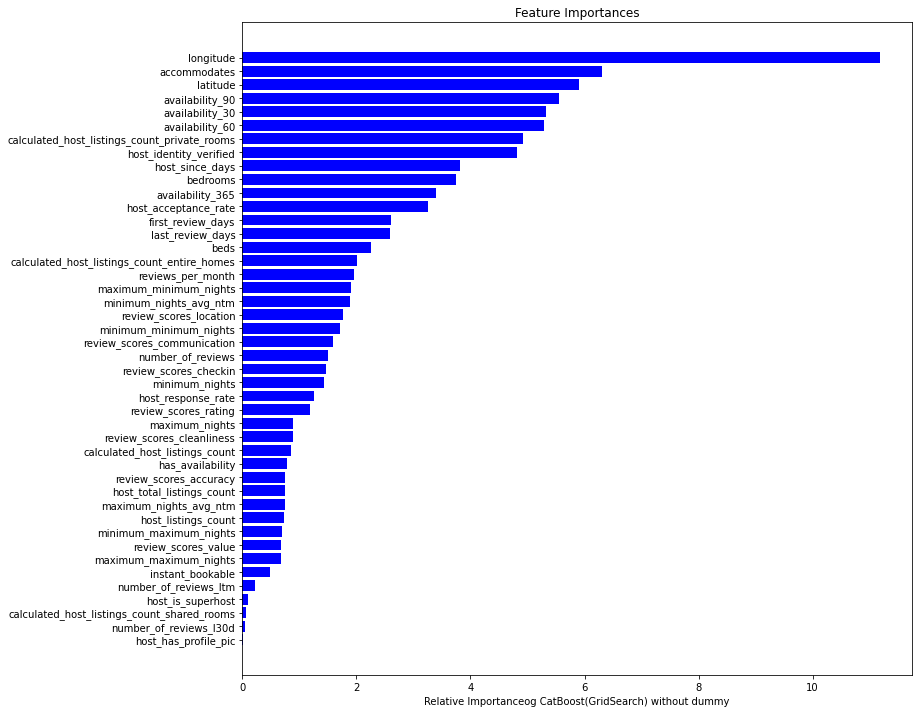

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = cb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),np.array(feature_names)[indices])
plt.xlabel('Relative Importanceog CatBoost(GridSearch) without dummy')


## CatBoost (fmin)

In [31]:
catboost_params = {
    'n_estimators':hp.quniform('n_estimators', 100, 800, 100),
    'max_depth':hp.quniform('max_depth', 5, 12, 1),
    'colsample_bylevel':hp.quniform('colsample_bylevel', 0.1, 0.8, 0.05),
    'min_child_samples':hp.quniform('min_child_samples', 50, 200, 50),
}

def hyperparameter_tuning_catboost(space):
    clf=CatBoostRegressor(n_estimators=int(space['n_estimators']),
                          max_depth=int(space['max_depth']), min_child_samples=space['min_child_samples'],
                          colsample_bylevel=space['colsample_bylevel'], learning_rate=0.01,
                          random_seed=42, logging_level='Silent')
    
    evaluation = [(X_test, y_test)]
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=200, verbose=False)
    y_pred = clf.predict(X_test)
    rmse = np.sqrt(((y_test-y_pred)**2).mean())
    return {'loss': rmse, 'status': STATUS_OK}

trials = Trials()
catboost_best = fmin(fn=hyperparameter_tuning_catboost, space=catboost_params, algo=tpe.suggest,
                     max_evals=100, trials=trials)
    
cb = CatBoostRegressor(n_estimators=int(catboost_best['n_estimators']),
                       max_depth=int(catboost_best['max_depth']), min_child_samples=catboost_best['min_child_samples'],
                       colsample_bylevel=catboost_best['colsample_bylevel'], learning_rate=0.01,
                       random_seed=42, logging_level='Silent')
evaluation = [(X_test, y_test)]
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)

test_score = cb.score(X_test, y_test)
train_score = cb.score(X_train, y_train)

100%|██████████████████████████████████████████████| 100/100 [30:42<00:00, 18.42s/trial, best loss: 0.6659901379416011]


In [32]:
test_score

0.3079925352527536

In [33]:
train_score

0.7577274680945203

In [34]:
cb.best_score_

{'learn': {'RMSE': 0.5339552564891735}}

In [35]:
catboost_best

{'colsample_bylevel': 0.35000000000000003,
 'max_depth': 12.0,
 'min_child_samples': 100.0,
 'n_estimators': 800.0}

Text(0.5, 0, 'Relative Importanceog CatBoost (fmin) without dummy')

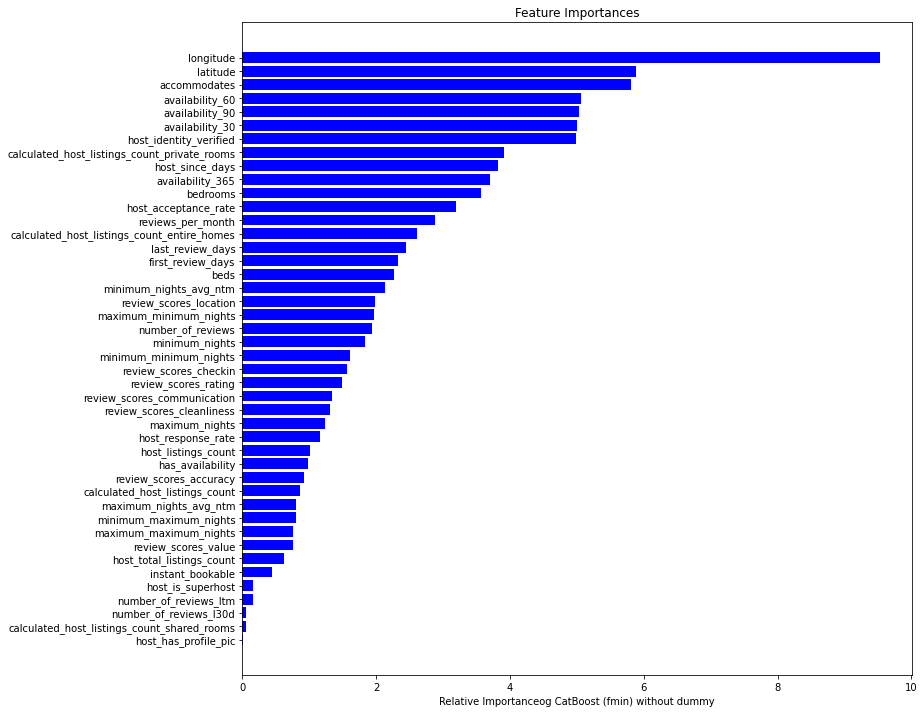

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = cb.feature_importances_
indices = np.argsort(importances)
#indices = indices[988-50:]

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)),feature_names)
plt.yticks(range(len(indices)),np.array(feature_names)[indices])
plt.xlabel('Relative Importanceog CatBoost (fmin) without dummy')


# Model by Cathy (Fangzi) -- non-scaler dataframe with no dummy variables

## Linear Regression

In [8]:
#Train test split
x = df.drop(columns=['price'])
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=4523)

In [9]:
lr_model = LinearRegression(normalize=True)
lr_model.fit(x_train,y_train)
#Predit base on the GBR model
lr_predict_train = lr_model.predict(x_train)
lr_predict_test = lr_model.predict(x_test)
#Calculate R square and MSE
print('R^2(Train): ' + str(r2_score(y_train, lr_predict_train)))
print('R^2(Test): ' + str(r2_score(y_test, lr_predict_test)))
print('MSE(Train): ' + str(mse(y_train, lr_predict_train)))
print('MSE(Test): ' + str(mse(y_test, lr_predict_test)))

R^2(Train): 0.12549744281008757
R^2(Test): 0.15291733949900632
MSE(Train): 67061.53782964427
MSE(Test): 51782.32035399387


## GBR Model

In [10]:
#Build GBR Model
gbr_model = GradientBoostingRegressor(**{'n_estimators': 1000,
                                         'max_depth': 5,
                                         'min_samples_split': 6,
                                         'learning_rate': 0.1,
                                         'criterion': 'mse'})
gbr_model.fit(x_train, y_train)
#Predit base on the GBR model
gbr_predict_train = gbr_model.predict(x_train)
gbr_predict_test = gbr_model.predict(x_test)
gbr_predict_test = gbr_model.predict(x_test)
#Calculate R square and MSE
print('R^2(Train): ' + str(r2_score(y_train, gbr_predict_train)))
print('R^2(Test): ' + str(r2_score(y_test, gbr_predict_test)))
print('MSE(Train): ' + str(mse(y_train, gbr_predict_train)))
print('MSE(Test): ' + str(mse(y_test, gbr_predict_test)))
#Get features from independent variables
features = x.columns

R^2(Train): 0.9809497886499211
R^2(Test): 0.4132754553020209
MSE(Train): 1460.8721936974266
MSE(Test): 35866.5803820527


In [11]:
#Find feature importance and sort them based on the magnitude
gbr_feature_importances = gbr_model.feature_importances_
sorted_index = np.argsort(gbr_feature_importances)
sorted_gbr_feature_importance = np.sort(gbr_feature_importances)
feature_importance_dict = {"index":features[sorted_index], "gbr feature importance":sorted_gbr_feature_importance}
feature_importance_df_nd = pd.DataFrame(data=feature_importance_dict)
feature_importance_df_nd

,index,gbr feature importance
0,number_of_reviews_l30d,0.000242
1,instant_bookable,0.000325
2,host_has_profile_pic,0.000690
3,calculated_host_listings_count_shared_rooms,0.000877
4,number_of_reviews_ltm,0.000909
5,host_is_superhost,0.001316
6,minimum_maximum_nights,0.001648
7,review_scores_accuracy,0.002005
8,host_listings_count,0.002626
9,maximum_nights,0.003580


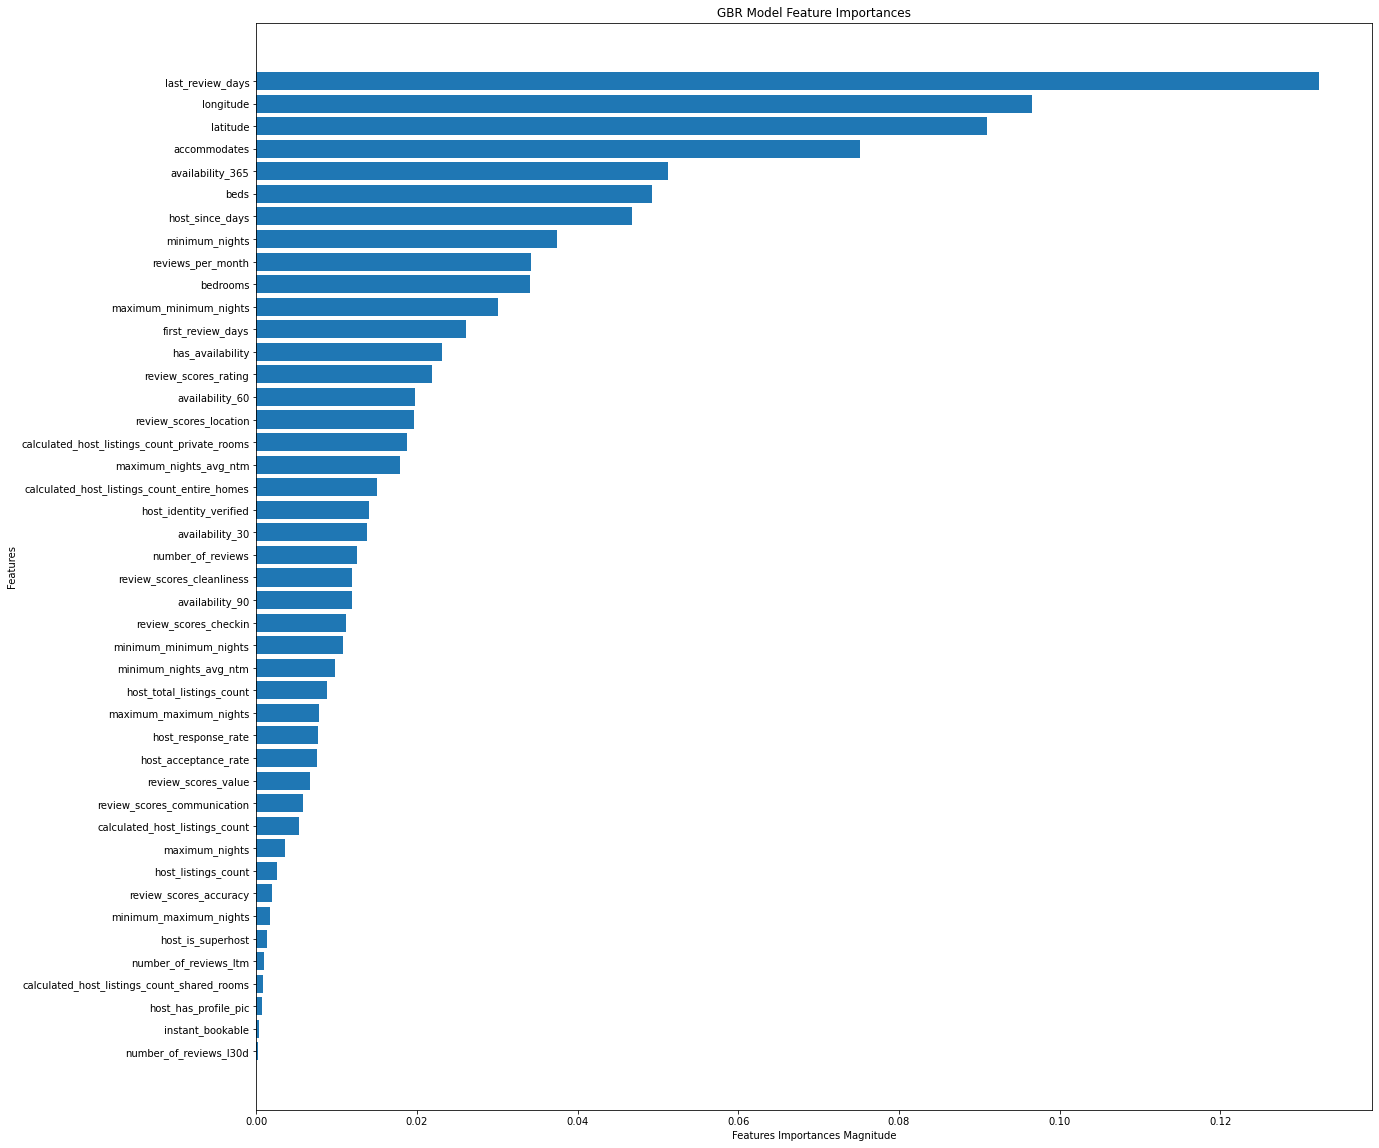

In [12]:
#Plot feature importance
feature_count = len(sorted_index)
feature_pos = np.arange(feature_count)
x = gbr_feature_importances[sorted_index]
y = features[sorted_index]

plt.figure(figsize=(20,20))
plt.yticks(feature_pos,y)
plt.barh(feature_pos, x)
plt.xlabel('Features Importances Magnitude')
plt.ylabel('Features')
plt.title('GBR Model Feature Importances')
plt.show()

## Random Forest

In [14]:
#Build Random Forest model
rf_model = RandomForestRegressor(max_depth=15,n_estimators=500)
rf_model.fit(x_train,np.ravel(y_train))
rf_model.score(x_test,y_test)

0.33594944195643994

In [15]:
#Predit base on the Random Forest model
rf_predict_train = rf_model.predict(x_train)
rf_predict_test = rf_model.predict(x_test)
#Calculate R square and MSE
print('R^2(Train): ' + str(r2_score(y_train, rf_predict_train)))
print('R^2(Test): ' + str(r2_score(y_test, rf_predict_test)))
print('MSE(Train): ' + str(mse(y_train, rf_predict_train)))
print('MSE(Test): ' + str(mse(y_test, rf_predict_test)))
params = {
    'n_estimators':(60,100,140),
    'max_depth':np.arange(4,11,2),
    'min_samples_split': np.arange(6,11,2),
    'min_samples_leaf': np.arange(6,11,2)
}

GridSearch_RF_model = GridSearchCV(RandomForestRegressor(),params,cv=3,iid=False)
GridSearch_RF_model.fit(x_train, np.ravel(y_train))
GridSearch_RF_model.best_score_, GridSearch_RF_model.best_params_

R^2(Train): 0.8670040213895702
R^2(Test): 0.33594944195643994
MSE(Train): 10198.843648249054
MSE(Test): 40593.53393861577


TypeError: __init__() got an unexpected keyword argument 'iid'

## Decision Tree

In [16]:
#Build Decision Tree model
dt_model = tree.DecisionTreeRegressor(max_depth=10,random_state=4523)
dt_model.fit(x_train,y_train)
dt_model.score(x_test,y_test)

-1.302507423623248

In [17]:
#Predit base on the Random Forest model
dt_predict_train = dt_model.predict(x_train)
dt_predict_test = dt_model.predict(x_test)
#Calculate R square and MSE
print('R^2(Train): ' + str(r2_score(y_train, dt_predict_train)))
print('R^2(Test): ' + str(r2_score(y_test, dt_predict_test)))
print('MSE(Train): ' + str(mse(y_train, dt_predict_train)))
print('MSE(Test): ' + str(mse(y_test, dt_predict_test)))

R^2(Train): 0.8245211692922405
R^2(Test): -1.302507423623248
MSE(Train): 13456.656183630312
MSE(Test): 140752.70642063656
